# TP1 : Perceptron pour la classification

Le but de ce TP est d'implémenter un réseau de neurones simple et de l'entraîner sur une tâche donnée en partant de zéro.

## Préparatifs

Les commandes suivantes permettent de charger les bibliothèques Python nécessaires.

In [1]:
# Importation des bibliothèques:
# - numPy pour la manipulation de vecteurs et de matrices (algèbre linéaire)
# - scikit-learn pour l'accès au jeu de données
# - pandas pour la visualisation des données sous forme de tableau
# - matplotlib pour la visualisation des données sous forme de graphe
# - random pour la génération de nombres aléatoires et la reproducibilité

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

seed = 1
random.seed(seed)
np.random.seed(seed)

## Exploration des données

Le jeu de données sur lequel vous allez travailler est de petite taille et s'intitule Iris.

Ce jeu de données bien connu contient les mesures de 150 iris, réparties en 3 espèces différentes (50 iris par espèce). Pour chaque iris, quatre mesures ont été efféctuées, correspondant à la longueur et la largeur des pétales et des sépales.

Une première étape va consister à charger ce jeu de données, puis à observer comment y sont structurées les données.

In [2]:
# Chargement des données
donnees = load_iris()

# Le champ "data" contient les observations (mesures)
print('Mesures des 3 premiers iris :')
print(donnees.data[0:3, :])
print()

# Le champ "target" contient les étiquettes de classe
print('Étiquettes des 3 premiers iris :')
print(donnees.target[0:3])
print()

# Le champ "feature_names" contient les noms des variables (features)
print('Nom des variables :')
print(donnees.feature_names)

Mesures des 3 premiers iris :
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]

Étiquettes des 3 premiers iris :
[0 0 0]

Nom des variables :
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


On note que les étiquettes sont des nombres entiers correspondant à l'espèce de l'iris qui a été mesuré. Celles-ci peuvent prendre la valeur 0, 1 ou 2 selon l'espèce.

Afin de visualiser les données plus facilement, on peut les charger dans un tableau `pandas`:

In [3]:
df = pd.DataFrame(data=np.c_[donnees['data'], donnees['target']], columns=donnees['feature_names'] + ['target'])

# pandas interprète automatiquement les données numériques comme des nombres à virgule flottante,
# alors qu'on souhaite que les étiquettes soient des nombres entiers. On les convertit donc
df.target = df.target.astype(int)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Visualisation 3D des trois premières variables

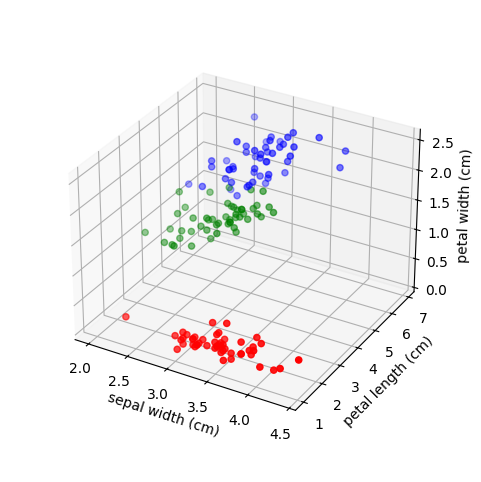

In [4]:
# Suivant la classe, les points affichés seront rouge, vert (green) ou bleus
cmp = np.array(['r', 'g', 'b'])

fig = plt.figure(figsize=(7, 6))  # Création d'une figure matplotlib
ax = fig.add_subplot(projection='3d')  # Ajout d'un graphe 3D à la figure

# Comme on est en 3 dimensions, on ne peut représenter que 3 variables. On choisit donc aléatoirement les 3 dernières variables (largeur des sépales, et longueur et largeur des pétales)
scatter = ax.scatter(donnees.data[:,1], donnees.data[:,2], donnees.data[:,3], c=cmp[donnees.target])  # Création du graphe 3D

# Ajout de titres aux axes
ax.set_xlabel(df.columns[1])
ax.set_ylabel(df.columns[2])
ax.set_zlabel(df.columns[3])
ax.set_box_aspect(None, zoom=0.85)
plt.show()

# Préparation des données

Le but va être d'entrainer un classificateur permettant de déduire l'espèce d'un iris en fonction de ses 4 mesures. Pour cela, plusieurs étapes de préparation des données vont être nécessaires :
- Encodage des étiquettes en 1 parmi n (*one-hot encoding*)
- Dans un premier temps, on va séparer les données en un jeu d'entraînement (*trainset*) et un jeu de test (*testset*)
- Ensuite, on va mélanger les données des deux ensembles

La première étape consiste à encoder les étiquettes. En effet, pour chaque échantillon de mesures, le classificateur produira un score (probabilité) pour chacune des trois espèces d'iris (par exemple [0.15, 0.46, 0.39], correspondant à 15% de chances que ce soit la première espèce, 46% de chances que ce soit la deuxième, et 39% que ce soit la dernière).
Plutôt que d'avoir des étiquettes entières, nous souhaitons donc les encoder comme suit :
- Espèce 1 : Étiquette [1, 0, 0]
- Espèce 2 : Étiquette [0, 1, 0]
- Espèce 3 : Étiquette [0, 0, 1]

Cette transformation nous permettra de comparer facilement les prédictions du modèle aux vraies valeurs durant l'entraînement.
Cette méthode d'encodage, appelée "encodage 1 parmi n" (*one-hot encoding*), peut être fait grâce à la classe `OneHotEncoder` de scikit-learn.

In [5]:
enc = OneHotEncoder(sparse_output=False)
labels = enc.fit_transform(donnees['target'].reshape(-1, 1))
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

Les deux étapes restantes (mélange et séparation) peuvent être effectuées ensemble grâce à la fonction `train_test_split` de scikit-learn :

In [6]:
# On garde 20% des données pour tester le classificateur
test_frac = 0.2

X_train, X_test, y_train, y_test = train_test_split(donnees['data'], labels, test_size=test_frac, shuffle=True, random_state=seed)

# On a désormais 4 jeux de données : deux jeux d'entraînement (mesures et classes) et deux de test.

print(X_train.shape)  # Il reste 80% des données (120/150) pour l'entraînement, avec 4 mesures par iris
print(y_train.shape)  # Les classes des 120 iris, encodées en 1 parmi n

print(X_test.shape)
print(y_test.shape)

(120, 4)
(120, 3)
(30, 4)
(30, 3)


# Classificateur

### Présentation

Le classificateur que nous allons implémenter dans cette partie est un perceptron à une seule couche. Ce modèle très simple est de la forme suivante :

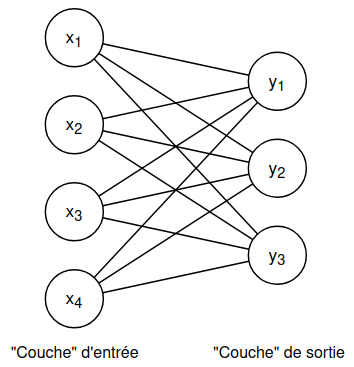

Comme on peut le constater, on dispose de 4 entrées, qui correspondent aux quatres mesures dont nous disposons pour chaque iris. En sortie, on souhaite obtenir trois scores correspondant aux probabilités que l'iris appartienne à chacune des trois classes.

Plus précisément, la fonction calculée par chaque neurone (à droite) est obtenue en multipliant chaque entrée par un *poids* (souvent noté $w$ pour *weight*), puis en sommant ces produits et en leur ajoutant une valeur supplémentaire (*biais*, souvent noté $b$). Enfin, ce résultat final passe par une fonction supplémentaire $h$ dite *fonction d'activation*.

Concrètement, l'image ci-dessous détaille le calcul effectué par le chaque neurone.

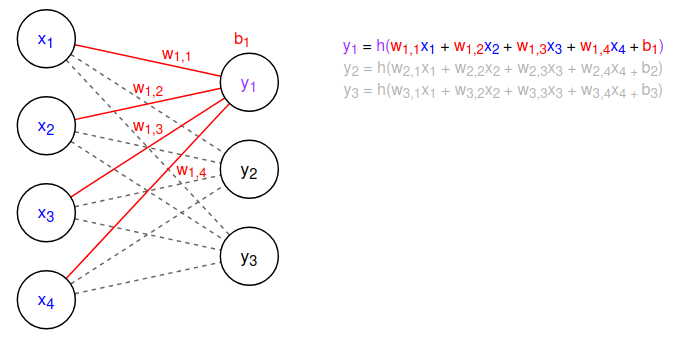

Il est possible de simplifier la notation de ces équations : en posant $W_1 = (w_{1,1}, ..., w_{1,4})$ et $X = (x_1, x_2, x_3, x_4)$, on obtient l'équation suivante (forme vectorielle) :

$$y_1 = h(W_1X+b_1)$$

On peut encore simplifier la notation en groupant les fonctions de tous les neurones : en posant $Y = (y_1, y_2, y_3)$, $W = (W_1, W_2, W_3)^T$ et $B = (b_1, b_2, b_3)$, on obtient finalement l'équation suivante (forme matricielle), qui régit le comportement du réseau de neurones entier :

$$Y = h(WX+B)$$

Nous disposons déjà des vecteurs X (mesures) et Y (étiquettes); il nous reste à définir le vecteur $B$ et la matrice $W$ ainsi que la fonction $h$.
Pour la fonction $h$, nous choisissons la fonction sigmoïde, définie par:
$$h(x) = \frac{1}{1 + e^{-x}}$$

In [7]:
# TODO: Définir la fonction d'activation sigmoïde, en utilisant la formule donnée ci-dessus.
# La fonction exponentielle peut être appliquée à chaque élément d'un vecteur en utilisant la fonction np.exp().
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Les valeurs contenues dans $B$ et de $W$ seront apprises au cours de l'entraînement du réseau de neurones. Nous allons commencer par les initialiser à des valeurs aléatoires :

In [8]:
# TODO: Initialiser les poids de W et B aléatoirement, en leur donnant leurs bonnes dimensions
w = np.random.randn(4, 3)  # On transforme 4 entrées (les 4 longueurs) en 3 sorties (une probabilité par classe)
b = np.random.randn(3)     # Un biais par neurone de sortie, donc 3 au total

Nous allons maintenant définir la fonction `forward()`, qui applique le réseau de neurones à un ensemble d'entrées données. Autrement dit, `forward(x)` doit renvoyer $Y=h(WX + B)$.

In [9]:
# TODO: Définir la fonction forward(), qui calcule et renvoie la sortie du réseau de neurones.
# Pour calculer un produit matriciel, on pourra utiliser la fonction np.matmul().
def forward(x):
    z = np.matmul(x, w) + b  # Attention, en raison de la manière dont fonctionne np.matmul(), il faut inverser les deux matrices ici
    a = sigmoid(z)
    return a

### Test sur un exemple

On peut d'ores et déjà observer les scores que le réseau de neurones (non entraîné) attribue à un exemple donné :

In [10]:
ex_donnees = X_train[0]
ex_classe = y_train[0]
scores = forward(ex_donnees)
scores

array([9.99999204e-01, 4.86076220e-02, 3.01495175e-05])

En principe, les scores retenus correspondent aux probabilités que l'iris appartienne à chacune des trois sous-espèces. Cependant, la somme des trois scores obtenues n'est pas de 1 ! Afin de remédier à ce problème, nous allons appliquer la fonction `softmax`, qui force un ensemble de scores à devenir des scores de probabilités valides :

In [11]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

softmax(scores)

array([0.57009486, 0.22017247, 0.20973267])

**Q1 :** Avant entraînement, quelle est la probabilité que l'iris donné appartienne à chacune des trois espèces, d'après le réseau de neurones ?

**Réponse :** On obtient un score de 57% pour la première classe, 22% pour la deuxième et 21% pour la première. On pourrait imaginer que les prédictions initiales sont de 33% pour chaque classe (équiprobables), mais ça n'est pas forcément le cas ! Puisque les poids sont initialisés aléatoirement, les prédictions initiales du réseau sont généralement complètement fausses. 

Afin d'évaluer la prédiction du réseau de neurones, il faut comparer celle-ci avec la vraie classe. Pour cela, on utilise une fonction de coût (*loss function*), qui va renvoyer un score correspondant à l'erreur faite par le réseau. Plus cette erreur est faible, plus le réseau de neurone est proche de la réalité.

La fonction de coût que nous allons utiliser ici s'appelle l'entropie croisée. Il s'agit de la fonction de coût classique utilisée pour des tâches de classification. Sa formule est donnée ci-dessous, où $\hat y$ est la prédiction du réseau de neurones, $y$ la vraie classe, et $n$ le nombre de classes :
$$L(y, \hat y) = -\sum_{i=1}^n y \log(\hat y)$$

In [12]:
# TODO: Implémenter la fonction de coût. On pourra utiliser les fonctions np.log() et np.sum()
def loss(y, y_hat):
    return - np.sum(y * np.log(y_hat))


**Q2 :** Quel score d'erreur est donné par la fonction de coût sur l'exemple d'iris utilisé à la question 1 ?

In [13]:
# TODO
loss(ex_classe, scores)  # Donne un score de 0.0032

3.0239749286071023

Un des avantages de la bibliothèque `numPy` est qu'elle nous permet de travailler sur l'ensemble des données en parallèle, et pas un seul exemple. Ainsi, il est possible de passer l'intégralité du jeu de données aux fonctions `sigmoid`, `forward`, `softmax` et `loss`, auquel cas ces fonctions renverront des matrices 2D au lieu de vecteurs, où des vecteurs au lieu d'une seule valeur.

### Boucle d'entraînement

Afin d'entraîner le réseau de neurones, la procédure est la suivante :

1. Faire passer l'ensemble des données d'entraînement par le réseau de neurones : $\hat Y = h(WX + B)$
2. Calculer la fonction de coût sur les prédictions du réseau de neurones : $l = L(\hat Y, Y)$
3. Calculer la manière dont la fonction de coût dépend de chacun des poids du réseau de neurones (gradient) : $\Delta W = \displaystyle\frac{\partial l}{\partial W}$ et $\Delta B = \displaystyle\frac{\partial l}{\partial B}$ (**rétropropagation**). Pour le perceptron que nous utilisons ici, on admettra les résultats suivants :
$$\Delta W = X^T(\hat Y - Y)$$
$$\Delta B = \sum(\hat Y - Y)$$
4. Mettre à jour chacun des poids du réseau de neurones en les faisant avancer un peu dans la direction inverse de celle calculée à l'étape 3, afin de s'approcher du minimum de la fonction de coût (**descente de gradient**).

L'idée de la descente de gradient peut être illustrée par l'image suivante :

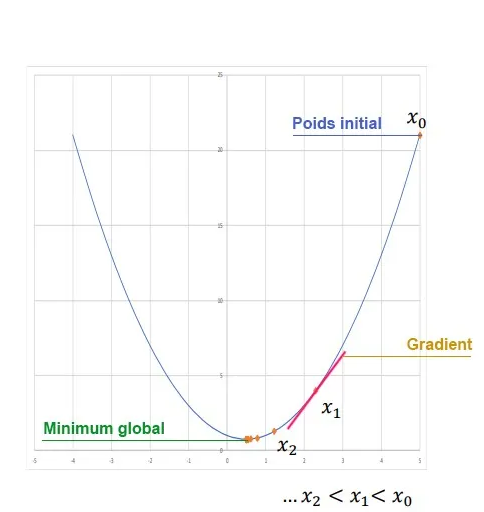

On essaye de varier chacun des poids du réseau de neurones (en abscisse) en suivant la pente de la fonction de coût (en ordonnée) afin d'avancer vers le minimum de celle-ci. En partant du poids initial $x_0$, on souhaite donc descendre la pente (gradient), et on change ainsi la valeur du poids à $x_1$. Une fois à $x_1$, la pente est plus faible, donc on descend moins loin, jusqu'à avoir le nouveau poids $x_2$. En répétant ceci de manière itérative, on souhaite se rapprocher du minimum de la fonction de coût.

Il est important d'avancer seulement un peu dans la direction souhaitée; si on avance trop, on risque de dépasser le minimum. En revanche, si on avance trop peu, il faudra trop d'itérations pour s'approcher du minimum. Pour calibrer cela, on va définir un paramètre appelé **taux d'apprentissage** (*learning rate*) et généralement noté $\eta$.

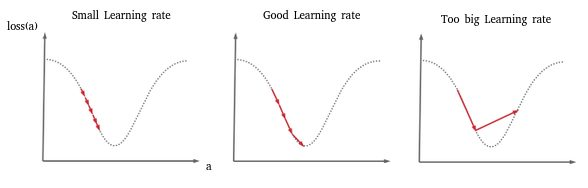

La mise à jour des poids du réseau de neurones se fait ensuite de manière suivante :
$$W \leftarrow W - \eta\Delta W$$
$$B \leftarrow B - \eta\Delta B$$

On répétera ensuite ces quatres étapes jusqu'à ce que le réseau de neurones aie suffisamment appris.

In [14]:
# Ré-initialisation des poids du réseau de neurones (pour pouvoir reproduire les résultats)
np.random.seed(seed)
w = np.random.randn(4, 3)
b = np.random.randn(3)

lr = 0.0001  # Taux d'apprentissage
epochs = 500  # Nombre d'itérations

epoch_losses = []  # Pour garder en mémoire le coût à chaque itération

for epoch in range(epochs):
    
    # Étape 1 : Faire passer les données dans le réseau de neurones
    pred = forward(X_train)

    # Étape 2 : Calcul de la fonction de coût
    epoch_loss = loss(y_train, pred)

    # Étape 3 : Calcul des gradients (rétropropagation)
    # TODO : Coder cette partie. On pourra utiliser la fonction `np.matmul` pour le produit matriciel.
    dz = pred - y_train
    dw = np.matmul(X_train.T, dz)
    db = np.sum(dz)
    
    # Étape 4 : Descente de gradient
    # TODO : Coder cette partie
    w -= lr * dw
    b -= lr * db

    epoch_losses.append(epoch_loss)
    
    if epoch % (epochs // 25) == 0:
        print(f"Coût à l'itération {epoch:<4}: {epoch_loss:.3f}")

Coût à l'itération 0   : 618.095
Coût à l'itération 20  : 283.045
Coût à l'itération 40  : 208.026
Coût à l'itération 60  : 187.750
Coût à l'itération 80  : 169.940
Coût à l'itération 100 : 154.285
Coût à l'itération 120 : 141.019
Coût à l'itération 140 : 130.088
Coût à l'itération 160 : 121.240
Coût à l'itération 180 : 114.129
Coût à l'itération 200 : 108.404
Coût à l'itération 220 : 103.758
Coût à l'itération 240 : 99.942
Coût à l'itération 260 : 96.766
Coût à l'itération 280 : 94.087
Coût à l'itération 300 : 91.795
Coût à l'itération 320 : 89.811
Coût à l'itération 340 : 88.073
Coût à l'itération 360 : 86.534
Coût à l'itération 380 : 85.158
Coût à l'itération 400 : 83.918
Coût à l'itération 420 : 82.791
Coût à l'itération 440 : 81.759
Coût à l'itération 460 : 80.810
Coût à l'itération 480 : 79.930


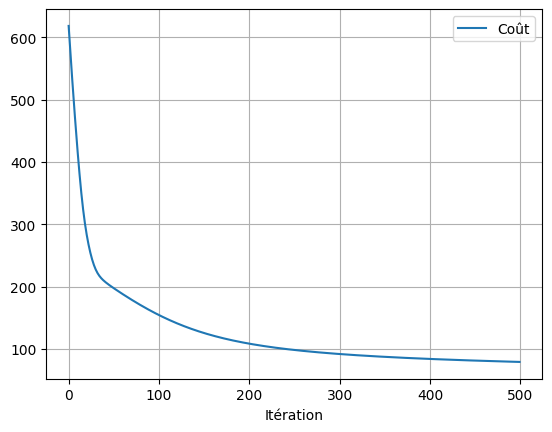

In [15]:
plt.plot(epoch_losses, label="Coût")
plt.xlabel("Itération")
plt.legend()
plt.grid("on")

**Q3 :** Le code ci-dessus permet d'observer l'évolution de la fonction de coût au cours de l'entraînement. Que remarquez-vous ?

**Réponse :** On remarque que l'erreur du réseau de neurones (coût) décroit bien au fur et à mesure que l'entraînement progresse.

**Q4 :** D'après le graphique, serait-il intéressant d'entraîner le réseau de neurones sur 50 itérations ? Et sur 2000 ?

**Réponse :** On voit qu'après 50 itérations, le coût décroit encore rapidement, il est donc a priori intéressant de continuer à l'entraîner. Cependant, on observe qu'après 500 itérations, le coût ne varie presque plus; continuer jusqu'à 2000 itérations est sans doute excessif et risque d'apporter peu d'améliorations supplémentaires..

**Q5 :** Faire varier le taux d'apprentissage, en testant par exemple les valeurs 0.000001 et 0.01, et observez à nouveau l'évolution de la fonction de coût. Que peut-on en déduire ?

**Réponse :** Pour une valeur de 0.000001, le réseau apprend beaucoup plus lentement, et la fonction de coût diminue peu. C'est donc sous-efficace, puisqu'il faudrait avoir un nombre d'itérations bien plus élevés pour arriver au même résultat. Pour une valeur de 0.01, l'entraînement est instable : Les poids sont déplacés trop loin dans le sens de la pente, si bien qu'ils dépassent le minimum et passent de l'autre côté. Le coût fluctue donc beaucoup sans jamais rester proche du minimum. Il est donc importer de bien calibrer son taux d'apprentissage.

La fonction suivante permet de calculer la précision du réseau de neurones entraîné, c'est-à-dire son taux de prédictions correctes :

In [16]:
def accuracy(yhat, y):
    # Conversion des probabilités en prédiction de classe
    # (la classe avec la probabilité la plus haute est considérée comme la prédiction du perceptron)
    predicted_classes = np.argmax(yhat, axis=1)
    true_classes = np.argmax(y, axis=1)
    
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

train_acc = accuracy(forward(X_train), y_train)
test_acc = accuracy(forward(X_test), y_test)

print(f"Précision sur le jeu d'entraînement : {train_acc:.1%}")
print(f"Précision sur le jeu de test :        {test_acc:.1%}")

Précision sur le jeu d'entraînement : 65.0%
Précision sur le jeu de test :        63.3%


**Q6 :** En s'assurant que le taux d'apprentissage est bien de 0.0001, exécuter à nouveau la boucle d'entraînement du réseau de neurones, en la faisant cette fois durer 50 itérations, puis 2000.

Que constatez-vous ? Cela est-il en accord avec ce que vous aviez prévu dans la question 4 ?

**Réponse :**
| Itérations                     | 50    | 500   | 2000  |
|--------------------------------|-------|-------|-------|
| Précision (jeu d'entraînement) | 30.8% | 65.0% | 85.8% |
| Précision (jeu de test)        | 20.0% | 63.3% | 73.3% |

Deux remarques à faire ici :
- La précision sur le jeu d'entraînement est toujours supérieur à celle obtenue sur le jeu de test. C'est normal ; le réseau de neurones obtient de meilleurs résultats sur les données dont il a appris que sur celles qu'il n'a jamais vues. C'est pour cela qu'il est toujours important de vérifier les "vraies" performances de son réseau, pour éviter le surapprentissage (*overfitting*), où le réseau de neurones apprend par cœur les données qu'on lui donne mais est incapable de généraliser sur d'autres données non vues. En pratique, on divise même le jeu de données en trois : un jeu d'entraînement, qui sert à effectuer l'entraînement initial, un jeu de validation, qu'on utilise pour ajuster différents paramètres du réseaux de neurones et observer ce qui semble marcher le mieux, et enfin un jeu de test, qui sert à mesurer les performances finales obtenues.
- La précision augmente avec le nombre d'itérations. Ici, contrairement à ce que l'on aurait pu croire, il est bien bénéfique de continuer à entraîner jusqu'à 2000 itérations ! En fait, ici, les performance augmentent même jusqu'à 5000 itérations, correspondant à une précision d'environ 95%. Après cela, le modèle stagne.